In [1]:
%load_ext autoreload

%autoreload 2



In [2]:
import pandas as pd
import os
# Import libraries necessary for this analysis
from itertools import  count

#import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

#from library import *
#from Models import *

import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

import seaborn as sns

from __future__ import division

import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline
%matplotlib notebook
izip = zip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
file = './users.xlsx'
df = pd.read_excel(file)

columns = df.describe().columns.tolist()

In [5]:
def ScatterMatrix(df):

    _, ax = plt.subplots(figsize=(20, 20))

    _ = pd.scatter_matrix(df.dropna(axis=0,how='any'), alpha=0.4, diagonal='kde', ax=ax)

In [6]:
def rulePCA(X,  n=2):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n)
    try:
        datapca = pca.fit_transform(X)
    except:
        print(X)
        raise

    return datapca, pca

dfpca = df[columns].copy()
dfpca.columns = ['d1','d2','d3']

In [7]:
X,pca  = rulePCA(df[columns])
dforig = df[columns].copy()
dfpca = pd.DataFrame(X,columns=['d1','d2'])

dfpca['d2'] = np.nan_to_num(dfpca['d1']**2 + np.log(dfpca['d2']))
dfpca['d1'] = np.nan_to_num(np.sin(dfpca['d1']))
dfpca['d3'] = np.cos(np.nan_to_num(dfpca['d1']  - dfpca['d3']))


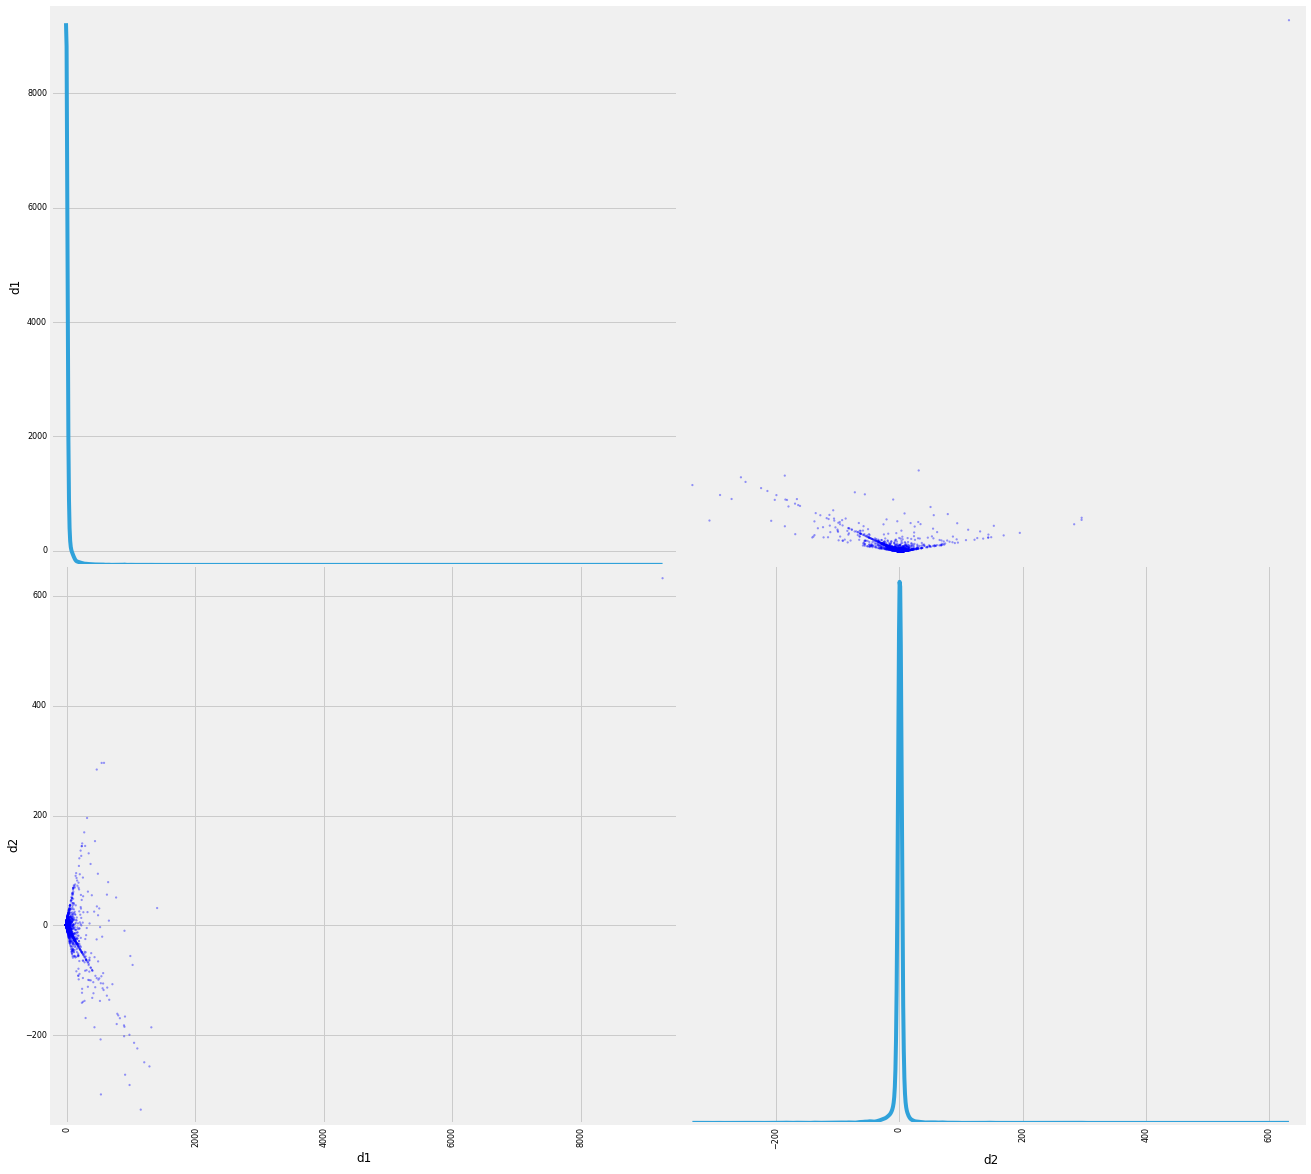

In [8]:

data_as_frame = dfpca.copy()
ScatterMatrix(dfpca)


In [9]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    #plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
        


    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float, count=len(events['anomalies_dict']))
    #plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [ ]:
rng = np.random.RandomState(42)

# Generate train data
X_train = data_as_frame[['d1', 'd2']].as_matrix()
X_test = data_as_frame.sample(n=1000).as_matrix()
X_outliers = data_as_frame.sample(n=100).as_matrix()

# fit the model
clf = IsolationForest(n_estimators=500, max_samples=50000, random_state=rng, n_jobs=48, contamination=0.1)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)


# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(data_as_frame['d1'].min().astype(int), data_as_frame['d1'].max().astype(int), 1000), np.linspace(data_as_frame['d2'].min().astype(int), data_as_frame['d2'].max().astype(int), 1000))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

df = pd.DataFrame(X_train)
df['output'] = y_pred_train

inliers = df.loc[df['output'] == 1].drop(columns='output').as_matrix()
outliers = df.loc[df['output'] == -1].drop(columns='output').as_matrix()

In [ ]:
_ = plt.figure(figsize=(15, 15))
plt.title("IsolationForest")

plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=20, edgecolor='k', alpha=0.3)
b2 = plt.scatter(inliers[:, 0], inliers[:, 1], c='green', s=20, edgecolor='k', alpha=0.3)
c = plt.scatter(outliers[:, 0], outliers[:, 1], c='red',  s=20, edgecolor='k', alpha=0.8)
plt.axis('tight')
plt.xlim((0, data_as_frame['d1'].max()))
plt.ylim((0, data_as_frame['d2'].max()))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")

plt.show()

In [ ]:
rng = np.random.RandomState(42)

# Generate train data
X_train = data_as_frame.as_matrix()
X_test = data_as_frame.sample(n=1000).as_matrix()
X_outliers = data_as_frame.sample(n=100).as_matrix()

# fit the model
clf = IsolationForest(n_estimators=500, max_samples=50000, random_state=rng, n_jobs=48, contamination=0.1)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)



df = pd.DataFrame(X_train)

df['output'] = y_pred_train
df.columns = ['d1', 'd2', 'output']

inliers = df.loc[df['output'] == 1].drop(columns='output').as_matrix()
outliers = df.loc[df['output'] == -1].drop(columns='output').as_matrix()

In [ ]:
dforig['output'] = df.output
dforig.columns = ['d1','d2','d3','output']

In [ ]:



Print_Report(df)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))


ax = fig.add_subplot(111, projection='3d')

ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], c='green', edgecolor='k', alpha=0.5)
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='red',  s=20, edgecolor='k', alpha=0.5)



ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')

plt.xlim((data_as_frame['d1'].min(), data_as_frame['d1'].max()))
plt.ylim((data_as_frame['d2'].min(), data_as_frame['d2'].max()))
ax.set_zlim(data_as_frame['d3'].min(), data_as_frame['d3'].max())
plt.show()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
x, y, z = inliers[:, 0], inliers[:, 1], inliers[:, 2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Inliers',
    mode='markers',
    marker=dict(
        color='green',
        size=1.5,
        symbol='circle',
        line=dict(
            color='green',
            width=0.1
        ),
        opacity=0.7
    )
)

x2, y2, z2 = outliers[:, 0], outliers[:, 1], outliers[:, 2]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    name='Outliers',
    mode='markers',
    marker=dict(
        color='red',
        size=2,
        symbol='circle',
        line=dict(
            color='red',
            width=0.1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    title='Anomaly Detection for d1',
    scene = dict(
    xaxis=dict(
        title='d1',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='d2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    zaxis=dict(
        title='d3',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
file = './Data/Report-20180704134629.xlsx'
df = pd.read_excel(file)

In [ ]:
Cluster0 = df.loc[df['Cluster'] == 0].drop(columns='Cluster').as_matrix()
Cluster1 = df.loc[df['Cluster'] == 1].drop(columns='Cluster').as_matrix()
Cluster2 = df.loc[df['Cluster'] == 2].drop(columns='Cluster').as_matrix()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
x, y, z = Cluster0[:, 0], Cluster0[:, 1], Cluster0[:, 2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Cluster0',
    mode='markers',
    marker=dict(
        color='green',
        size=1.5,
        symbol='circle',
        line=dict(
            color='green',
            width=0.1
        ),
        opacity=0.7
    )
)

x2, y2, z2 = Cluster1[:, 0], Cluster1[:, 1], Cluster1[:, 2]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    name='Cluster1',
    mode='markers',
    marker=dict(
        color='red',
        size=2,
        symbol='circle',
        line=dict(
            color='red',
            width=0.1
        ),
        opacity=0.9
    )
)
x3, y3, z3 = Cluster2[:, 0], Cluster2[:, 1], Cluster2[:, 2]
trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    name='Cluster2',
    mode='markers',
    marker=dict(
        color='blue',
        size=2,
        symbol='circle',
        line=dict(
            color='blue',
            width=0.1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2, trace3]
layout = go.Layout(
    title='\nClustering for Securitas',
    scene = dict(
    xaxis=dict(
        title='d1',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='d2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    zaxis=dict(
        title='d3',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')